# Text Classification using Sci-Kit Learn

### Consumer Complaint Database

The csv contains complaints data.gov has received about financial products and services. 

Details about the dataset - 

    0	- "consumer" <br/>
    1	- "finance" <br/>
    2	- "complaint" <br/>
    3	- "bank account" <br/>
    4	- "bank service" <br/>
    5	- "credit card" <br/>
    6	- "credit report" <br/>
    7	- "debt collection" <br/>
    8	- "money transfer" <br/>
    9	- "mortgage" <br/>
    10	- "student loan" <br/>
    11	- "loan" <br/>

##### data url

https://catalog.data.gov/dataset/consumer-complaint-database


##### metadata

https://catalog.data.gov/harvest/object/f88b9cb6-5465-428b-8aa9-0f971eb5538f


### Problem 

The problem is supervised text classification problem, and our goal is to investigate which supervised machine learning methods are best suited to solve it.

Given a new complaint comes in, we want to assign it to one of 12 categories. The classifier makes the assumption that each new complaint is assigned to one and only one category. This is multi-class text classification problem. I can’t wait to see what we can achieve!


#### Input: 

Consumer_complaint_narrative

#### Output:

Product


In [37]:
# load libraries

import os
import gc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


In [2]:
# helper to load dataframe and display 
# how to call this function
# df, col_types, cat_cols = load_dataframe(f_name)

def load_dataframe(f_name):
    '''
    helper f() to load dataframe
    display basic details
       
    '''
    # load dataframe
    df = pd.read_csv(f_name, sep=',', index_col=None, skiprows=None, chunksize=None, 
                 low_memory=False, encoding='utf-8', keep_default_na=True, 
                 na_values='', na_filter=True, nrows=None, engine='c')
    
    # number of columns
    n = len(df.columns)
    
    # display all columns
    pd.options.display.max_columns = n
    
    # columns
    columns = list(df.columns)
    
    # categorical columns
    cat_cols = df.select_dtypes(include=['object'])
    cat_cols = list(cat_cols)
    
    # column types
    col_types = []
    for i in range(n):
        if df.dtypes[i] not in col_types:
            col_types.append(df.dtypes[i])

    print("Basic dataframe details!!")
    
    print("Dataframe dimensions")
    print("")
    
    print("Shape of dataframe: ", df.shape)
    print("")
    
    print("Number of rows: ", len(df))
    print("")
    
    print("Number of columns: ", len(df.columns))
    print("")
    
    print("Is dataframe empty: ", df.empty)
    print("")
    
    print("Describe")
    print(df.describe())
    print("")
    
    print("Describe (including categoricals)")
    print(df.describe(include='all'))
    print("")
    
    print("Info")
    print(df.info())
    print("")
    
    print("Null check")
    print(df.isnull().sum())
    print("")
    
    print("Columns")
    print(columns)
    print("")
    
    print("Dataframe data types")
    print(df.dtypes)
    print("")
    
    print("Column types")
    print(col_types)
    print("")
    
    print("Categorical Columns")
    print(cat_cols)
    print("")
    
    print("Sample data")
    print(df.sample(5))
    print("")
    
    return df, col_types, cat_cols

In [3]:
# correlation plot

def corr_heatmap(df):
    # asusming you have a dataframe df
    correlations = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(correlations, dtype=np.bool)
    # array([[False, False],
    #       [False, False]])
    
    mask[np.triu_indices_from(mask)] = True
    # array([[ True,  True],
    #       [False,  True]])
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 7))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

In [4]:
# helper to treat missing values

# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [5]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

In [6]:
# Plot validation curve
def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, cv)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(param_range, train_mean, color='r', marker='o', markersize=5, label='Training score')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='r')
    plt.plot(param_range, test_mean, color='g', linestyle='--', marker='s', markersize=5, label='Validation score')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='g')
    plt.grid() 
    plt.xscale('log')
    plt.legend(loc='best') 
    plt.xlabel('Parameter') 
    plt.ylabel('Score') 
    plt.ylim(ylim)

---

In [7]:
# file details

f_directory = 'C:\\Users\\praveen\\Downloads\\'
f_name = 'Consumer_Complaints.csv'

# change directory
os.chdir(f_directory)

# check whether file is present in current directory
if not f_name in os.listdir():
    sys.exit()

In [8]:
# load dataframe

df, col_types, cat_cols = load_dataframe(f_name)

Basic dataframe details!!
Dataframe dimensions

Shape of dataframe:  (1110575, 18)

Number of rows:  1110575

Number of columns:  18

Is dataframe empty:  False

Describe
       Complaint ID
count  1.110575e+06
mean   1.746641e+06
std    9.072512e+05
min    1.000000e+00
25%    9.735945e+05
50%    1.876426e+06
75%    2.593322e+06
max    3.006706e+06

Describe (including categoricals)
       Date received   Product       Sub-product  \
count        1110575   1110575            875406   
unique          2464        18                76   
top       09/08/2017  Mortgage  Credit reporting   
freq            3553    262949            143569   
mean             NaN       NaN               NaN   
std              NaN       NaN               NaN   
min              NaN       NaN               NaN   
25%              NaN       NaN               NaN   
50%              NaN       NaN               NaN   
75%              NaN       NaN               NaN   
max              NaN       NaN            

        Date received                  Product  \
473830     11/27/2015         Credit reporting   
339313     10/08/2014          Debt collection   
410375     09/28/2012                 Mortgage   
1048646    03/25/2016              Credit card   
46386      03/22/2012  Bank account or service   

                                    Sub-product  \
473830                                      NaN   
339313                              Credit card   
410375   Conventional adjustable mortgage (ARM)   
1048646                                     NaN   
46386                          Checking account   

                                            Issue  \
473830     Incorrect information on credit report   
339313                      Communication tactics   
410375   Loan servicing, payments, escrow account   
1048646                                  Late fee   
46386                    Deposits and withdrawals   

                                       Sub-issue Consumer complaint narra

In [9]:
# missing values
draw_missing_data_table(df)

,Total,Percent
Tags,958043,0.862655
Consumer complaint narrative,794155,0.715085
Company public response,748666,0.674125
Consumer consent provided?,549683,0.494954
Sub-issue,508403,0.457784
Consumer disputed?,342032,0.307977
Sub-product,235169,0.211754
ZIP code,84171,0.075790
State,14131,0.012724
Company response to consumer,5,0.000005


In [10]:
gc.collect()

144

In [11]:
# for this problem, we need only two columns
# Consumer complaint narrative and Product

req_col = ['Consumer complaint narrative', 'Product']

df = df[req_col]

In [12]:
# missing values
draw_missing_data_table(df)

,Total,Percent
Consumer complaint narrative,794155,0.715085
Product,0,0.000000


In [13]:
df.sample(3)

,Consumer complaint narrative,Product
258583,NaN,Mortgage
229473,NaN,Checking or savings account
1026396,I have attempted over the past week to set up ...,Student loan


In [14]:
# selecting only columns without missing values
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [15]:
# missing values
draw_missing_data_table(df)

,Total,Percent
Product,0,0.0
Consumer complaint narrative,0,0.0


In [16]:
# encode values in Product column
df['Category_id'] = df['Product'].factorize()[0]

df.sample(4)

,Consumer complaint narrative,Product,Category_id
950746,I have tried numerous times to dispute a bill ...,"Credit reporting, credit repair services, or o...",10
364777,I am trying to cancel my XXXX credit cards wit...,Credit card,3
933038,This debt was paid in FULL over seven years ag...,Debt collection,1
950176,i was foreclosed on in XX/XX/XXXX. my house wa...,Mortgage,2


In [17]:
# category tf-idf
category_id_df = df[['Product', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_id_df

,Product,Category_id
5,Credit reporting,0
10,Debt collection,1
21,Mortgage,2
30,Credit card,3
87,Vehicle loan or lease,4
124,Bank account or service,5
134,Money transfers,6
189,Student loan,7
214,Consumer Loan,8
226,"Payday loan, title loan, or personal loan",9


In [18]:
# map product -> categories
category_to_id = dict(category_id_df.values)
category_to_id

{'Bank account or service': 5,
 'Checking or savings account': 16,
 'Consumer Loan': 8,
 'Credit card': 3,
 'Credit card or prepaid card': 14,
 'Credit reporting': 0,
 'Credit reporting, credit repair services, or other personal consumer reports': 10,
 'Debt collection': 1,
 'Money transfer, virtual currency, or money service': 15,
 'Money transfers': 6,
 'Mortgage': 2,
 'Other financial service': 11,
 'Payday loan': 12,
 'Payday loan, title loan, or personal loan': 9,
 'Prepaid card': 13,
 'Student loan': 7,
 'Vehicle loan or lease': 4,
 'Virtual currency': 17}

In [19]:
id_to_category = dict(category_id_df[['Category_id', 'Product']].values)
id_to_category

{0: 'Credit reporting',
 1: 'Debt collection',
 2: 'Mortgage',
 3: 'Credit card',
 4: 'Vehicle loan or lease',
 5: 'Bank account or service',
 6: 'Money transfers',
 7: 'Student loan',
 8: 'Consumer Loan',
 9: 'Payday loan, title loan, or personal loan',
 10: 'Credit reporting, credit repair services, or other personal consumer reports',
 11: 'Other financial service',
 12: 'Payday loan',
 13: 'Prepaid card',
 14: 'Credit card or prepaid card',
 15: 'Money transfer, virtual currency, or money service',
 16: 'Checking or savings account',
 17: 'Virtual currency'}

In [20]:
df.head()

,Consumer complaint narrative,Product,Category_id
5,An account on my credit report has a mistaken ...,Credit reporting,0
10,This company refuses to provide me verificatio...,Debt collection,1
21,Started the refinance of home mortgage process...,Mortgage,2
22,"In XXXX, I and my ex-husband applied for a ref...",Mortgage,2
23,I have disputed several accounts on my credit ...,Credit reporting,0


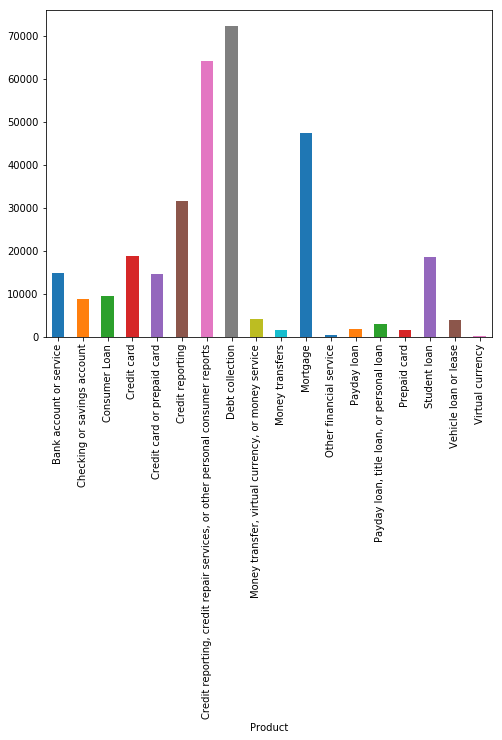

In [21]:
# full data
fig = plt.figure(figsize=(8,6))
df.groupby('Product')['Consumer complaint narrative'].count().plot.bar(ylim=0)
plt.show()

In [22]:
df.shape

(316420, 3)

In [23]:
# For learning purpose, we'll use a random sample of 1000 rows

df = df.sample(1000)
df.shape

(1000, 3)

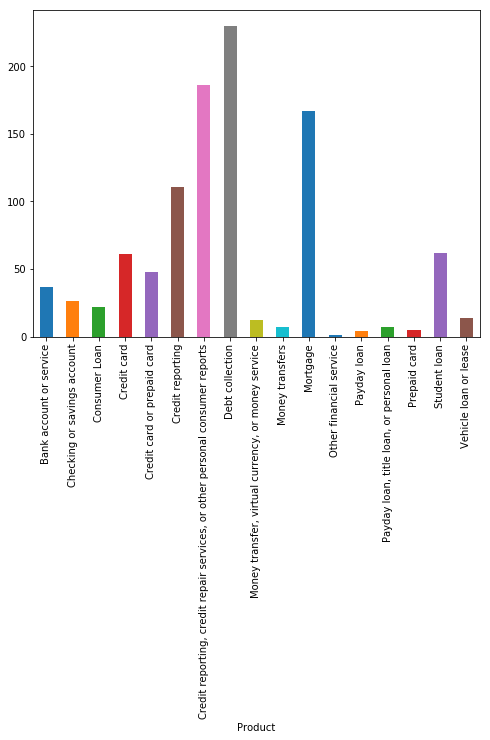

In [24]:
fig = plt.figure(figsize=(8,6))
df.groupby('Product')['Consumer complaint narrative'].count().plot.bar(ylim=0)
plt.show()

### Multi-Class Classifier: Features and Design

1. To train supervised classifiers, we first transformed the “Consumer complaint narrative” into a vector of numbers. We explored vector representations such as TF-IDF weighted vectors.

2. After having this vector representations of the text we can train supervised classifiers to train unseen “Consumer complaint narrative” and predict the “product” on which they fall.

In [25]:
# tf-idf
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', 
                        encoding='latin-1', ngram_range=(1, 2), stop_words='english')

tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='latin-1', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [26]:
features = tfidf.fit_transform(df['Consumer complaint narrative']).toarray()
features.shape

(1000, 2972)

In [27]:
labels = df['Category_id']
labels.shape

(1000,)

### Correlation between words in features


In [28]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels==category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. checking
. paypal
  . Most correlated bigrams:
. debit card
. checking account
# 'Checking or savings account':
  . Most correlated unigrams:
. checking
. overdraft
  . Most correlated bigrams:
. savings account
. checking account
# 'Consumer Loan':
  . Most correlated unigrams:
. vehicle
. lease
  . Most correlated bigrams:
. pay monthly
. loan company
# 'Credit card':
  . Most correlated unigrams:
. macy
. card
  . Most correlated bigrams:
. charged late
. credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. card
. clerk
  . Most correlated bigrams:
. pay account
. balance transfer
# 'Credit reporting':
  . Most correlated unigrams:
. experian
. equifax
  . Most correlated bigrams:
. negative information
. verify accounts
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
. mistakes
. inquiries
  . Most correlated bigrams:
. data breach
. r

In [29]:
gc.collect()

3709

### Modeling

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df['Consumer complaint narrative'], df['Product'], random_state = 0)
X_train.shape

(750,)

In [32]:
count_vect = CountVectorizer()
count_vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [33]:
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts

<750x6309 sparse matrix of type '<class 'numpy.int64'>'
	with 65010 stored elements in Compressed Sparse Row format>

In [38]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [39]:
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf

<750x6309 sparse matrix of type '<class 'numpy.float64'>'
	with 65010 stored elements in Compressed Sparse Row format>

In [40]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)
clf

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [41]:
# sample prediction
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']
